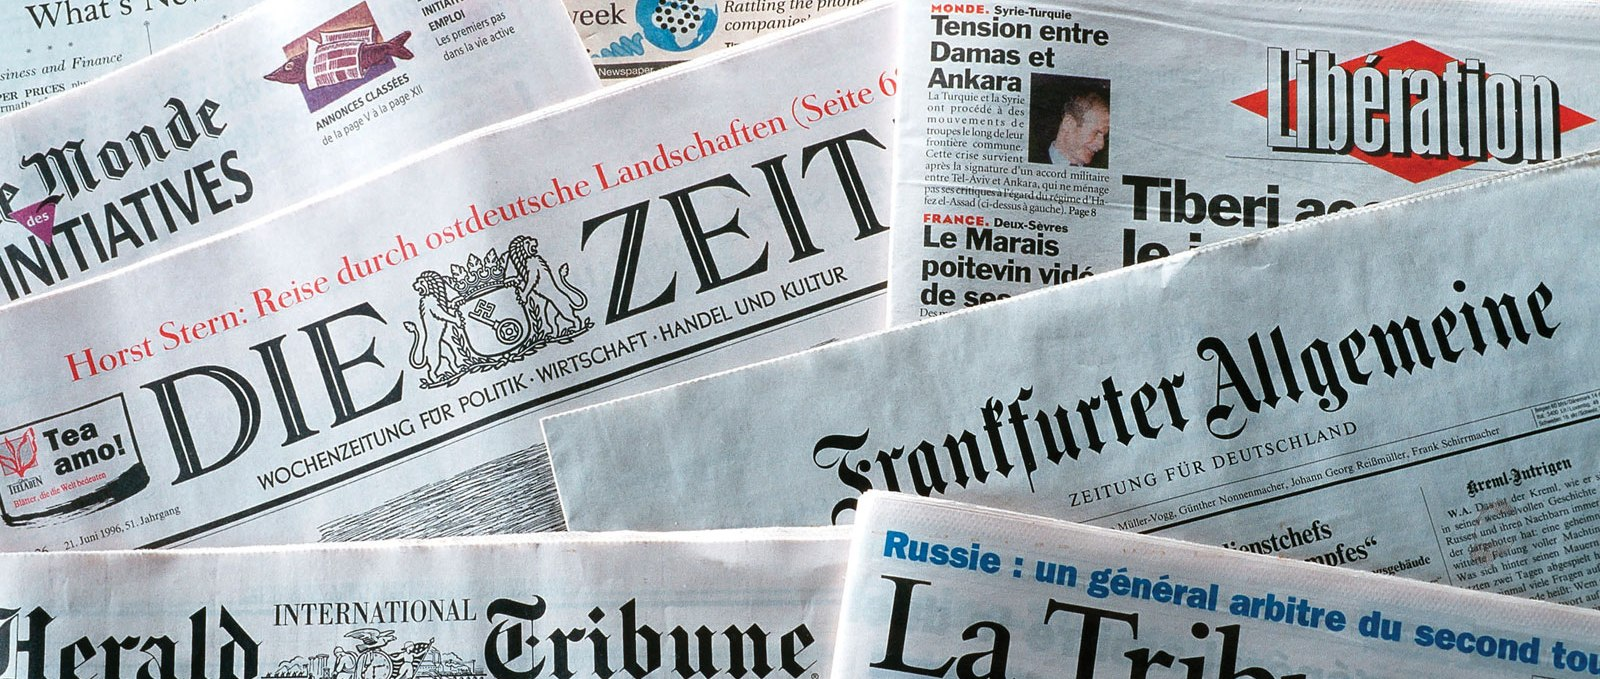

# Fake News

### Intro
* lable == 1: unreliable
* label == 0: reliable

***
## My Workflow

#### 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

#### 2. Check out my data
* Check Shape / Info / Describe

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Label Percent
* Text length / Word length per Label Percent

#### 4. Preprocessing Data
* Null value processing
* Drop columns

#### 5. Feature Engineering
* Concat "author" & "text" Columns
* Nomalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data

#### 6. Modeling
* LSTM Modeling
* Bert Modeling

#### 7. Submission
* Submit the predictions
<br/><br/>
***

# 1. Import & Install libray
* Import Basic libray
* Import Enginnering libray

In [10]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau



from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


plt.style.use('seaborn')
sns.set(font_scale=2.5)
%matplotlib inline

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
train_df = pd.read_csv('/kaggle/input/more-params-dataset2/train.tsv', sep='\t')

test_df = pd.read_csv('/kaggle/input/more-params-dataset2/test.tsv', sep='\t')
train_df.head()

,id,label,text,subject,author,status,state,party,p1,p2,p3,p4,p5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


# 2. Check out my data
* Check Shape / Info / Describe

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10239 non-null  object 
 1   label    10239 non-null  object 
 2   text     10239 non-null  object 
 3   subject  10237 non-null  object 
 4   author   10237 non-null  object 
 5   status   7342 non-null   object 
 6   state    8031 non-null   object 
 7   party    10237 non-null  object 
 8   p1       10237 non-null  float64
 9   p2       10237 non-null  float64
 10  p3       10237 non-null  float64
 11  p4       10237 non-null  float64
 12  p5       10237 non-null  float64
 13  context  10137 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [14]:
train_df.describe()

,p1,p2,p3,p4,p5
count,10237.000000,10237.000000,10237.000000,10237.000000,10237.000000
mean,11.534336,13.287682,17.135391,16.435870,6.202012
std,18.974349,24.113808,35.847862,36.153089,16.129599
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [15]:
print("[text] ",train_df['text'][0])
print("[author] ",train_df['author'][0])
print("[subject] ",train_df['subject'][0])
print("[status] ",train_df['status'][0])
print("[state] ",train_df['state'][0])
print("[party] ",train_df['party'][0])

[text]  When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
[author]  scott-surovell
[subject]  energy,history,job-accomplishments
[status]  State delegate
[state]  Virginia
[party]  democrat


# 3. Preprocessing Data
* Null value processing
* Drop columns

In [16]:
train_df[train_df['text'].isnull()].head()
train_df['text'].fillna("", inplace=True)
test_df['text'].fillna("", inplace=True)

In [17]:
train_df[train_df['subject'].isnull()].head()
train_df['subject'].fillna("", inplace=True)
test_df['subject'].fillna("", inplace=True)

In [18]:
train_df[train_df['author'].isnull()].head()
train_df['author'] = train_df['author'].fillna('unknown')
test_df['author'] = test_df['author'].fillna('unknown')

In [19]:
train_df[train_df['status'].isnull()].head()
train_df['status'].fillna("", inplace=True)
test_df['status'].fillna("", inplace=True)

In [20]:
train_df[train_df['state'].isnull()].head()
train_df['state'].fillna("", inplace=True)
test_df['state'].fillna("", inplace=True)

In [21]:
train_df[train_df['party'].isnull()].head()
train_df['party'].fillna("", inplace=True)
test_df['party'].fillna("", inplace=True)

In [22]:
train_df[train_df['context'].isnull()].head()
train_df['context'].fillna("", inplace=True)
test_df['context'].fillna("", inplace=True)

# 4. Feature Engineering
* Concat "author" & "text" Columns
* Nomalization
* Plot WordClouds
* Words Tokenization
* Split Train / Test / Validation Data

In [23]:
train_df['text']= train_df['author'] + " " + train_df['text'] + " " + train_df['subject'] + " " + train_df['status'] + " " + train_df['state'] + " " + train_df['party'] + " " + train_df['context']
test_df['text']= test_df['author'] + " " + test_df['text'] + " " + test_df['subject'] + " " + test_df['status'] + " " + test_df['state'] + " " + test_df['party'] + " " + test_df['context']

In [24]:
train_df.drop(['id','author','subject','status','state','party','context'], axis=1, inplace=True)
test_df.drop(['id','author','subject','status','state','party','context'], axis=1, inplace=True)

In [25]:
train_df['text'][0]

'scott-surovell When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration. energy,history,job-accomplishments State delegate Virginia democrat a floor speech.'

In [26]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [27]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

In [28]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x))
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x))

# 5. Modeling
* Bert Modeling

### - BERT Modeling

In [72]:
!pip install --quiet transformers
from transformers import TFBertModel, BertTokenizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [113]:
#get BERT layer
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

#get BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [114]:
encode = bert_tokenizer.encode("Hi nice meet you !")
decode = bert_tokenizer.decode(encode)

print("Encode: ", encode)
print("Decode: ", decode)

Encode:  [101, 7632, 3835, 3113, 2017, 999, 102]
Decode:  [CLS] hi nice meet you! [SEP]


In [115]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [116]:
# Map the labels in the second column to numerical values
# label_mapping = {
#     "true": 1.0,
#     "mostly-true": 0.75,
#     "half-true": 0.5,
#     "barely-true": 0.25,
#     "false": 0,
#     "pants-fire": -0.25
# }

label_mapping = {
    "true": 1.0,
    "mostly-true": 0.8,
    "half-true": 0.6,
    "barely-true": 0.4,
    "false": 0.2,
    "pants-fire": 0
}

y_train_bert = train_df['label'].replace(label_mapping)

x_train_bert = train_df['text']
# y_train_bert = train_df['label']

train_input_ids, train_attention_masks = bert_encode(x_train_bert,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [117]:
input_ids = tf.keras.Input(shape=(60,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

output = bert_layers([input_ids,attention_masks])
output = output[1]
net = tf.keras.layers.Dense(32,activation='relu')(output)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net

model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [77]:
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from transformers import TFBertModel

# input_ids = Input(shape=(60,), dtype='int32', name='input_ids')
# attention_mask = Input(shape=(60,), dtype='int32', name='attention_mask')
# # Define input for additional numerical features
# additional_features = Input(shape=(5,), dtype='float32', name='additional_features')

# # Load BERT model
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')
# bert_output = bert_model([input_ids, attention_mask]).pooler_output  # Use pooled output

# # Combine BERT output with additional features
# combined = Concatenate()([bert_output, additional_features])

# # Add dense layers for classification
# net = Dense(128, activation='relu')(combined)
# net = Dropout(0.2)(net)
# net = Dense(64, activation='relu')(net)
# net = Dropout(0.2)(net)
# # output = Dense(1, activation='sigmoid')(net)  # Binary classification
# output = Dense(1)(net)

# # Define the model
# model = tf.keras.Model(inputs=[input_ids, attention_mask, additional_features], outputs=output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

In [118]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
#               loss='mean_squared_error',
#               metrics=['mae'])  # Mean Absolute Error for metrics

In [119]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_9 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 32)           24608       tf_bert_model_9[0][1]      

In [120]:
# print(y_train_bert.dtypes)
print(y_train_bert.unique())

[0.6 0.8 0.2 1.  0.4 0. ]


In [81]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(train_additional_features.shape)
print(y_train_bert.shape)

(10239, 60)
(10239, 60)
(10239, 5)
(10239,)


In [1]:
# train_additional_features = train_df[['p1', 'p2', 'p3', 'p4', 'p5']].values

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_additional_features = scaler.fit_transform(train_additional_features)

history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train_bert,
    validation_split=0.2, 
    epochs=10,
    batch_size=32)

NameError: name 'model' is not defined

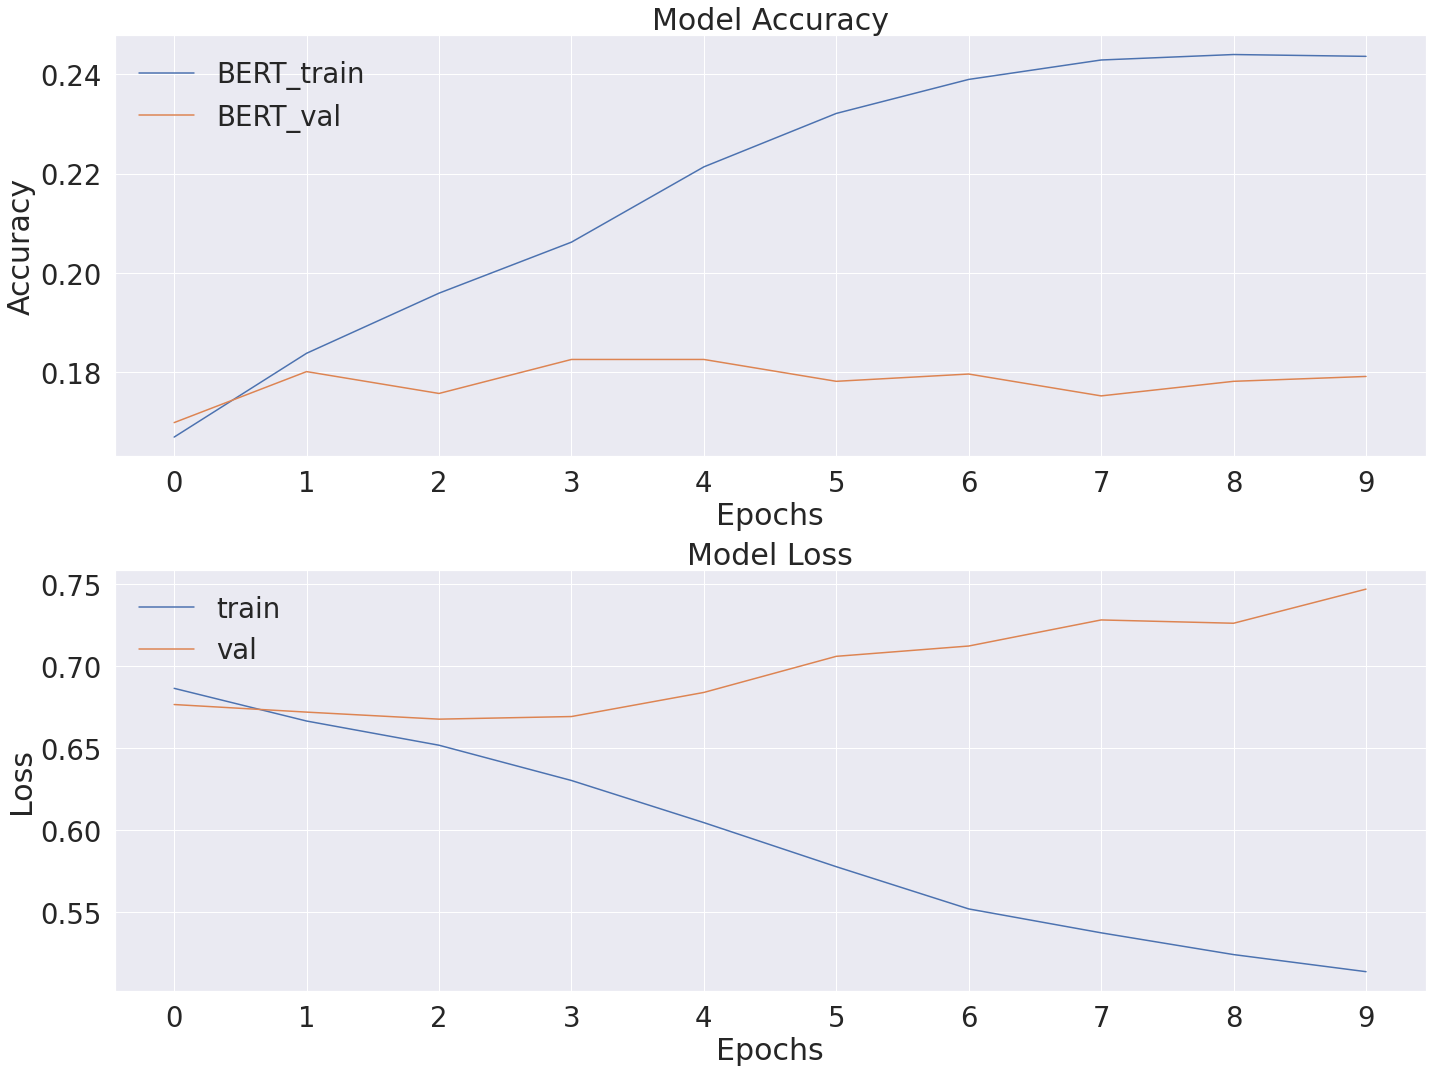

In [122]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9])
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

In [123]:
# bins = [-0.25, 0, 0.25, 0.5, 0.75, 1]
# predicted_classes = np.digitize(predictions, bins) - 1  # Convert to 0-based indexing
# true_classes = np.digitize(y_test, bins) - 1  # Do the same for true labels

bert_x_test = test_df['text']
bert_y_test = test_df['label'].replace(label_mapping)

test_input_ids, test_attention_masks = bert_encode(bert_x_test,60)

pred = model.predict([test_input_ids,test_attention_masks])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [124]:
from sklearn.metrics import f1_score

# # Convert probabilities to binary labels
# threshold = 0.5
# y_pred_labels = (pred > threshold).astype(int)

bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
predicted_classes = np.digitize(pred, bins) - 1  # Convert to 0-based indexing
true_classes = np.digitize(bert_y_test, bins) - 1  # Do the same for true labels

f1 = f1_score(true_classes, predicted_classes, average='micro')  # Use 'micro', 'macro', or 'weighted'
print("F1 Score:", f1)

from sklearn.metrics import confusion_matrix


F1 Score: 0.376892274636195


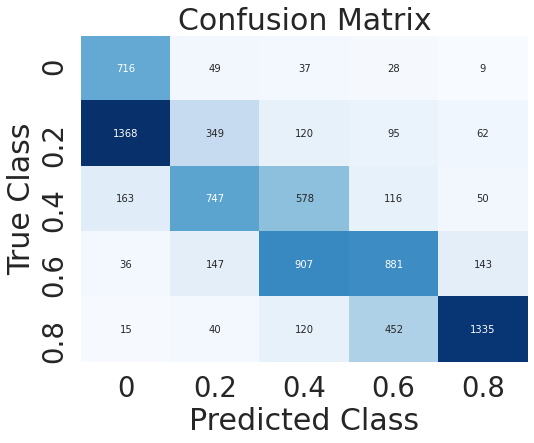

Unique True Classes: [0 1 2 3 4 5]
Unique Predicted Classes: [0 1 2 3 4]


In [126]:
# Plot the confusion matrix
bert_y_test = np.clip(bert_y_test, 0, 1)
pred = np.clip(pred, 0, 1)

bins = [0, 0.2, 0.4, 0.6, 0.8, 1]  # Ensure bins match your expected class range
true_classes = np.digitize(bert_y_test, bins) - 1
predicted_classes = np.digitize(pred, bins) - 1

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes, labels=[0, 1, 2, 3, 4])


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=bins[:-1], yticklabels=bins[:-1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print("Unique True Classes:", np.unique(true_classes))
print("Unique Predicted Classes:", np.unique(predicted_classes))

##### reference
* https://www.kaggle.com/mnavaidd/tweet-classification-using-lstm-bert/notebook?select=glove.6B.zip
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
